In [1]:
import os
import torch
import torchvision
# import torchvision.transforms as transforms
from torchvision import transforms, utils, datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
from rich import print
from rich.progress import track
from skimage import io, transform


seed = 100
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

lr = 0.02
batch_size = 32


hidden_neurons = 32
conv_layers =  4



if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print('Running on GPU: {}.'.format(torch.cuda.get_device_name()))
else:
    print('Running on CPU.')

In [2]:
class FacialRecognitialDataset:
    def __init__(self, transformation = None, root='.', validSize=0.2, trainSize=0.7, testSize=0.1,
                 randomSeed=100, shuffle=True, num_workers=4, batchSize=64):
        
        self._loadFullDataset(root=root,firstRun=True)
        miu, sig = self._getMeanStd()
        self._loadFullDataset(miu=miu, sig=sig, firstRun=False)
        self._loadData(validSize, trainSize, testSize, randomSeed, batchSize, num_workers)
        
    def _getMeanStd(self):
        nimages = 0
        mean = 0.
        std = 0.
        for batch, _ in self.fulldataset:
            # Rearrange batch to be the shape of [B, C, W * H]
            batch = batch.view(batch.size(0), batch.size(1), -1)
            # Update total number of images
            nimages += batch.size(0)
            
            # Compute mean and std here
            mean += batch.mean(2).sum(0) 
            std += batch.std(2).sum(0)
        mean /= nimages
        std /= nimages

        return mean, std

    def _loadFullDataset(self, root ="", miu=None, sig=None, firstRun=False):
        if firstRun==False:
            self.transform = transforms.Compose([
                                transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((miu[0], miu[1], miu[2]), (sig[0], sig[1], sig[2]))])
        else:
            self.transform = None
        self.fulldataset = datasets.ImageFolder(root=root, transform = self.transform)
        
    def _loadData(self, validSize, trainSize, testSize, randomSeed, batchSize):
        num = len(self.fulldataset)
        indices = list(range(num))
        split = int(np.floor(validSize * num))
        testSplit = int(np.floor(testSize*num))
        
        #doesn't really matter since we use subsetrandomsampler lol
        np.random.seed(randomSeed)
        np.random.shuffle(indices)
        
        validIdx, testIdx, trainIdx = indices[:split], indices[split:testSplit], indices[testSplit:]
        trainSample = SubsetRandomSampler(trainIdx)
        validSample = SubsetRandomSampler(validIdx)
        testSample = SubsetRandomSampler(testIdx)
        
        self.train = utils.data.DataLoader(
            self.fulldataset, batch_size=batchSize, sampler=trainSample, num_workers=num_workers
        )
        self.valid = utils.data.DataLoader(
            self.fulldataset, batch_size=batchSize, sampler=validSample, num_workers=num_workers
        )
        self.test = utils.data.DataLoader(
            self.fulldataset, batch_size=batchSize, sampler=testSample, num_workers=num_workers
        )

In [20]:
# FRD = FacialRecognitialDataset(root="./alldata")

def load_data_first_time(desired=None):
    preset_mean = [0.0, 0.0, 0.0]
    preset_std = [0.0, 0.0, 0.0]

    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize(preset_mean, preset_std)])

    data_asl = torchvision.datasets.ImageFolder(root='./alldata', transform=transform)
    random.shuffle(data_asl.imgs)

    classes_asl = data_asl.classes

    print (data_asl.imgs[:5])
    print (classes_asl)
    print (data_asl.class_to_idx)

    num_classes = len(data_asl.classes)

    print (len(data_asl))
    
    return data_asl
# load_data_first_time()
data_asl = load_data_first_time()
classes_asl = data_asl.classes

In [55]:
def getMeanStd(data_asl):
    nimages = len(data_asl)
    mean = 0.
    std = 0.
    
    for img, _ in data_asl:
#         print (img.shape)
#         print (img)
        arr = np.array(img)
#         print (arr.mean(1).sum(1).shape)
        
        # Compute mean and std here
        mean += arr.mean(1).sum(1) 
        std += arr.std(1).sum(1)
        
    mean /= nimages
    std /= nimages

    return mean, std


# from PIL import Image
# with open('./alldata/Extra/face278_bc557e96-2a9c-11eb-9f53-002432182720.jpg', 'rb') as f:
#     img = Image.open(f)
#     print (img.convert('RGB'))

pretransform = transforms.Compose([
    transforms.Resize(60),
    transforms.CenterCrop(60),
    transforms.ToTensor()
])


# d = datasets.ImageFolder(root='./alldata', transform = pretransform)
# print (getMeanStd(d))

# all
# means = [16072.07266965,  9746.96245215,  9121.04768495]
# stds = [5672.89046695, 4212.2042784 , 4014.49080251]

def load_fulldata(desired=None):
#     means = [22.977926, 14.072051, 13.135243] #[5859.37201659, 3588.365     , 3349.48313634]
#     stds = [6.766082 , 4.9459076, 4.655467 ] #[1829.12540701, 1365.50856512, 1296.0798618 ]
    means = [23, 14, 13]
    stds = [7 , 5, 5]
    
    # transforms.Normalize(means, stds)
    
    transform = transforms.Compose([
        transforms.Resize(60),
        transforms.CenterCrop(60),
        transforms.ToTensor(),
        ])

    fulldataset = datasets.ImageFolder(root='./alldata', transform = transform)
    random.shuffle(fulldataset.imgs)
    
    if desired:
        for i in range(len(fulldataset)):
            img , label = fulldataset.imgs[i]
            if label == desired:
                fulldataset.imgs[i] = (img, 1)
            else:
                fulldataset.imgs[i] = (img, 0)
    
    print (fulldataset.imgs[:15])
    
    

    return fulldataset

fulldataset = load_fulldata()


In [48]:
batch_size = 32


n = len(fulldataset)
n_train = int(0.75 * n)
n_valid = int(0.15 * n)
n_test  = int(0.1 * n)


train_set = torch.utils.data.Subset(fulldataset, range(0, n_train))
valid_set = torch.utils.data.Subset(fulldataset, range(n_train, n_train + n_valid))
test_set  = torch.utils.data.Subset(fulldataset, range(n_train + n_valid, n))


train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_set,  batch_size=batch_size, shuffle=True)
len(train_loader), len(valid_loader), len(test_loader)


(151, 31, 21)

In [60]:
class Net(nn.Module):
    def __init__(self, hidden=32, conv_num=4):
        super(Net, self).__init__()
        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv_norm = nn.BatchNorm2d(20)
#         self.conv_norm15 = nn.BatchNorm2d(15)
#         self.conv_norm20 = nn.BatchNorm2d(20)
#         self.conv_norm30 = nn.BatchNorm2d(30)

        self.conv1 = nn.Conv2d(3,  20, 3)
        self.conv2 = nn.Conv2d(20, 20, 3)
        self.conv3 = nn.Conv2d(20, 20, 3)
        self.conv4 = nn.Conv2d(20, 20, 3)
        hidden=15
        self.fc1 = nn.Linear(20, hidden)
        self.lin_norm = nn.BatchNorm1d(hidden)
        self.fc2 = nn.Linear(hidden, 7)

        
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv_norm(self.conv1(x))))
        x = self.pool(F.relu(self.conv_norm(self.conv2(x))))
        x = self.pool(F.relu(self.conv_norm(self.conv3(x))))
        x = self.pool(F.relu(self.conv_norm(self.conv4(x))))
        
        x = x.view(-1,20)
        x = F.relu(self.lin_norm(self.fc1(x)))
        x = self.fc2(x)
        
        return x
    
def evaluate_validation(model, v, show, loss_fnc):
    total = 0
    correct = 0
    vloss = 0
    
    for data in v:
        images, labels = data
        outputs = model(images.type(torch.cuda.FloatTensor))
        labels = labels.type(torch.cuda.LongTensor)
        
        vloss += loss_fnc(input=outputs.squeeze(), target=labels)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
#         print (predicted)
#         print (labels)
#         print ("")
        correct += (predicted == labels).sum().item()
        
        if show:
            for i in range(len(predicted)):
                if predicted[i] != labels[i]:
                    print (images[i])
                    plt.imshow(torchvision.utils.make_grid(images[i].reshape(60, 60, 3))) #.reshape(60, 60, 3)
                    plt.show()
                    
                    print ("predicted:", classes_asl[predicted[i]], "is", classes_asl[labels[i]])
        
    return float(correct)/float(total), vloss.item()/len(v)

In [ ]:
model = Net()
if torch.cuda.is_available():
    model = model.cuda()
    
    
lr = 0.03 # 96.6%
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)


optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fnc = nn.CrossEntropyLoss().cuda()
# loss_fnc = nn.MSELoss().cuda()
epochs = 30


losses = []
vlosses = []
vaccs = []
accs = []
tlosses = []
k=0

from time import time

start = time()
best_vacc = 0

print ("start training")
for epoch in range(epochs):
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        
        
        optimizer.zero_grad()
        outputs = model(inputs.type(torch.cuda.FloatTensor))
        labels = labels.type(torch.cuda.LongTensor)
        loss = loss_fnc(input=outputs.squeeze(), target=labels)
        
        loss.backward()
        optimizer.step()
        
#         print (labels)
#         print (outputs)
        
        
    if (epoch)%1 == 0:
        vacc, vloss = evaluate_validation(model, valid_loader, False, loss_fnc)
#         acc, tloss = evaluate_validation(model, train_loader, False, loss_fnc)

#         accs.append(acc)
#         tlosses.append(tloss)
#         vaccs.append(vacc)
#         losses.append(loss)
        vlosses.append(vloss)
        
#         print('[%d, %.1f] loss: %.4f, acc: %.1f **********' % (epoch + 1, time()-start, tloss, acc*100))
        if vacc > best_vacc:
            best_vacc = vacc
            print('[%d, %.1f] loss: %.4f, acc: %.1f **********' % (epoch + 1, time()-start, vloss, vacc*100))
        else:
            print('[%d, %.1f] loss: %.4f, acc: %.1f' % (epoch + 1, time()-start, vloss, vacc*100))

print ("Batch size", batch_size)
print('Total Time:', time()-start)

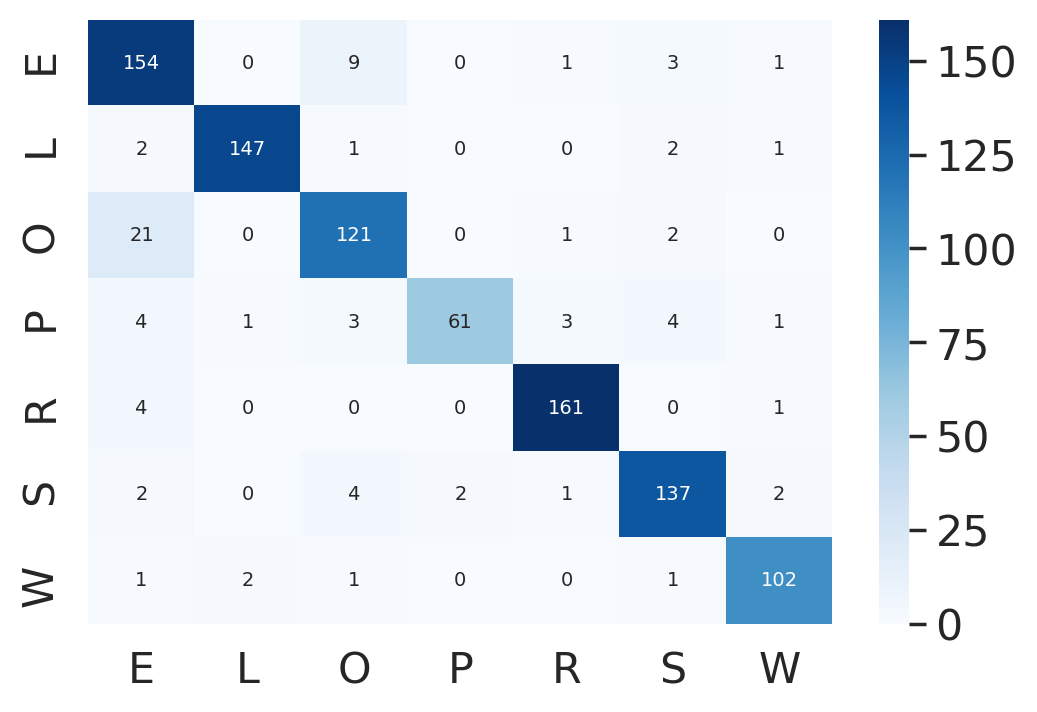

(0.9037267080745341, 0.2964194388616653)

In [137]:
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

y_true = []
y_pred = []

for data in test_loader:
        images, labels = data
        
        for i in range(len(labels)):
            y_true.append(labels[i])
        
        outputs = model(images.type(torch.cuda.FloatTensor))
        labels = labels.type(torch.cuda.LongTensor)
        
        _, predicted = torch.max(outputs.data, 1)
        y_pred += list(predicted.float())
        
y_true = [int(c) for c in y_true]
y_pred = [int(c) for c in y_pred]

conf_matrix = confusion_matrix(y_true, y_pred)
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf_matrix, index = [i for i in "ELOPRSW"],
                  columns = [i for i in "ELOPRSW"])


# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 7}, fmt='g', cmap="Blues") # font size
plt.savefig('Confusion.jpg')
plt.show()

evaluate_validation(model, test_loader, False, loss_fnc)
# for a,b in zip(y_pred, y_true):
#     if a != b:
#         print (a,b)

In [66]:
# {'Extra': 0, 'Leonard': 1, 'Other': 2, 'Penny': 3, 'Raj': 4, 'Sheldon': 5, 'Wolowitz': 6}
desired =  5
fulldataset = load_fulldata(desired)

batch_size = 32


n = len(fulldataset)
n_train = int(0.75 * n)
n_valid = int(0.15 * n)
n_test  = int(0.1 * n)


train_set = torch.utils.data.Subset(fulldataset, range(0, n_train))
valid_set = torch.utils.data.Subset(fulldataset, range(n_train, n_train + n_valid))
test_set  = torch.utils.data.Subset(fulldataset, range(n_train + n_valid, n))


train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_set,  batch_size=batch_size, shuffle=True)
len(train_loader), len(valid_loader), len(test_loader)

for data in train_set:
        images, labels = data
        for image in images:
            result = torchvision.utils.make_grid(image)
            print (result)
            plt.imshow(torchvision.utils.make_grid(image.reshape(60, 60, 3))) #.reshape(60, 60, 3)
            plt.show()
        break

RuntimeError: shape '[60, 60, 3]' is invalid for input of size 3600

In [57]:
class BinaryNet(nn.Module):
    def __init__(self, hidden=32, conv_num=4):
        super(BinaryNet, self).__init__()
        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv_norm = nn.BatchNorm2d(20)
        
        self.conv1 = nn.Conv2d(3,  20, 3)
        self.conv2 = nn.Conv2d(20, 20, 3)
        self.conv3 = nn.Conv2d(20, 20, 3)
        self.conv4 = nn.Conv2d(20, 20, 3)
        hidden=10
        self.fc1 = nn.Linear(20, hidden)
        self.lin_norm = nn.BatchNorm1d(hidden)
        self.fc2 = nn.Linear(hidden, 2) # could also try to do 2 to see if there is any difference

        
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv_norm(self.conv1(x))))
        x = self.pool(F.relu(self.conv_norm(self.conv2(x))))
        x = self.pool(F.relu(self.conv_norm(self.conv3(x))))
        x = self.pool(F.relu(self.conv_norm(self.conv4(x))))
        
        x = x.view(-1,20)
        x = F.relu(self.lin_norm(self.fc1(x)))
        x = self.fc2(x)
        
        return x
    

In [58]:


model = BinaryNet()
if torch.cuda.is_available():
    model = model.cuda()
    
    
lr = 0.06 # 96.6%
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)


optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fnc = nn.CrossEntropyLoss().cuda()
# loss_fnc = nn.MSELoss().cuda()

# loss_fnc = nn.BCELoss().cuda()

epochs = 5#30


losses = []
vlosses = []
vaccs = []
accs = []
tlosses = []
k=0

from time import time

start = time()
best_vacc = 0

print ("start training")
for epoch in range(epochs):
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        
        
        optimizer.zero_grad()
        outputs = model(inputs.type(torch.cuda.FloatTensor))
        labels = labels.type(torch.cuda.LongTensor)
        loss = loss_fnc(input=outputs.squeeze(), target=labels)
        
        loss.backward()
        optimizer.step()
        
#         print (labels)
#         print (outputs)
        
        
    if (epoch)%1 == 0:
        vacc, vloss = evaluate_validation(model, valid_loader, False, loss_fnc)
#         acc, tloss = evaluate_validation(model, train_loader, False, loss_fnc)

#         accs.append(acc)
#         tlosses.append(tloss)
        vaccs.append(vacc)
#         losses.append(loss)
        vlosses.append(vloss)
        
#         print('[%d, %.1f] loss: %.4f, acc: %.1f **********' % (epoch + 1, time()-start, tloss, acc*100))
        if vacc > best_vacc:
            best_vacc = vacc
            print('[%d, %.1f] loss: %.4f, acc: %.1f **********' % (epoch + 1, time()-start, vloss, vacc*100))
        else:
            print('[%d, %.1f] loss: %.4f, acc: %.1f' % (epoch + 1, time()-start, vloss, vacc*100))

print ("Batch size", batch_size)
print('Total Time:', time()-start)

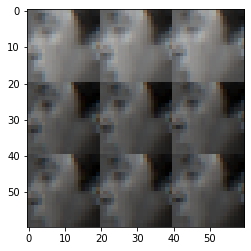

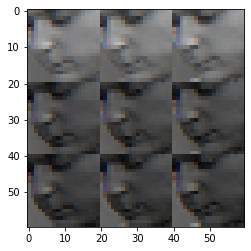

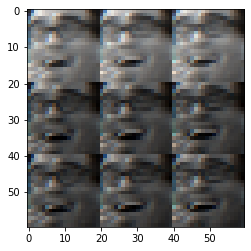

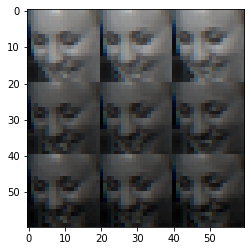

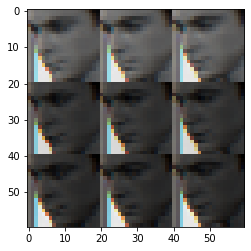

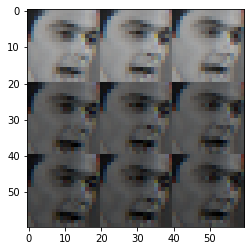

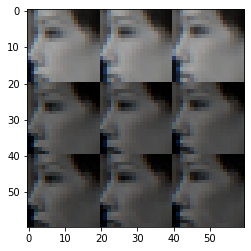

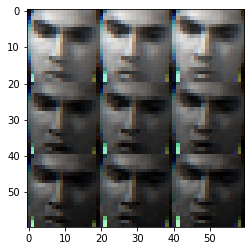

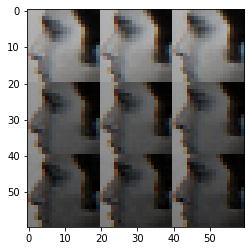

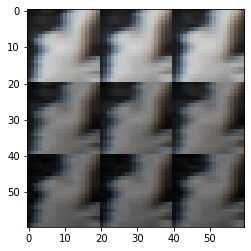

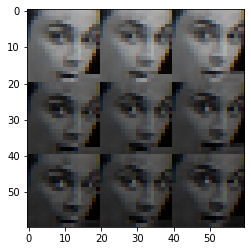

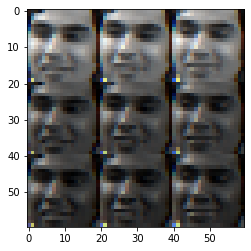

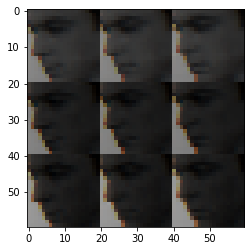

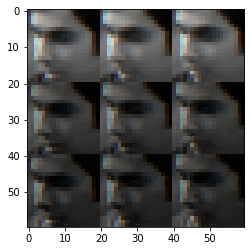

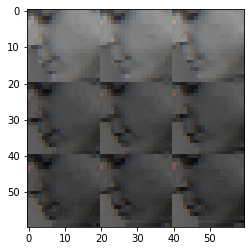

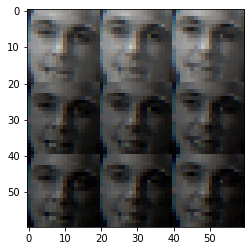

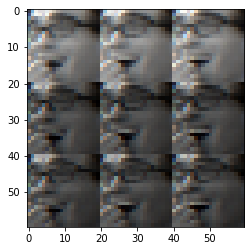

In [61]:
tacc, tloss = evaluate_validation(model, test_loader, True, loss_fnc)

No hypertuning, standard models, lr=0.03 (sheldon 0.06)
~4min training time

- Leonard: 99.3% 
- Penny: 99.5%
- Raj: 99.3%
- Sheldon: 98.5%
- Wolowitz: 99.4%


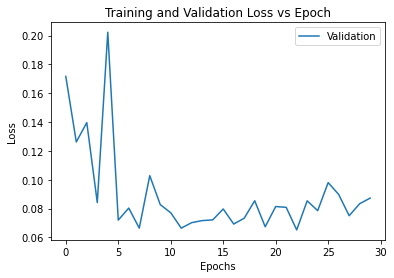

In [89]:
nRec = range(len(vlosses))
plt.plot(nRec, vlosses, label="Validation")
# plt.plot(nRec, tlosses, label="Training")
plt.title("Training and Validation Loss vs Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Loss.jpg')
plt.show()

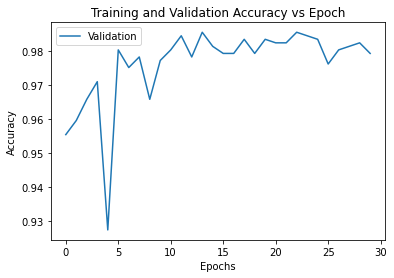

In [90]:
nRec = range(len(vaccs))
plt.plot(nRec, vaccs, label="Validation")
# plt.plot(nRec, accs, label="Training")
plt.title("Training and Validation Accuracy vs Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('Accuracy.jpg')
plt.show()

[]